In [ ]:
# ============================================================
# 0) INSTALL
# ============================================================
!pip -q install ultralytics ensemble-boxes scikit-learn opencv-python matplotlib seaborn pandas tqdm

import os, glob, json
import cv2
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
from ensemble_boxes import weighted_boxes_fusion
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("").project("face_emotion_recognition-fer2025_ml_project_uiu_spring2025")
version = project.version(8)
dataset = version.download("")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face_Emotion_Recognition-(fer2025_ml_project_uiu_spring2025)-8 in yolov11:: 100%|██████████| 14784/14784 [00:01<00:00, 8143.06it/s]


In [ ]:
# ============================================================
# 1) PATHS (based on your Colab structure)
# ============================================================
ROOT = "/content"                 # in colab
IMG_DIR = os.path.join(ROOT, "/fer/train/images")
W_Y8  = os.path.join(ROOT, "best_y8.pt")
W_Y11 = os.path.join(ROOT, "best_y11.pt")

OUT_DIR = os.path.join(ROOT, "hybrid_out")
os.makedirs(OUT_DIR, exist_ok=True)

PRED_IMG_DIR = os.path.join(OUT_DIR, "pred_images")
PRED_LBL_DIR = os.path.join(OUT_DIR, "pred_labels")
os.makedirs(PRED_IMG_DIR, exist_ok=True)
os.makedirs(PRED_LBL_DIR, exist_ok=True)

print("IMG_DIR:", IMG_DIR)
print("W_Y8   :", W_Y8)
print("W_Y11  :", W_Y11)
print("OUT_DIR:", OUT_DIR)

IMG_DIR: /fer/train/images
W_Y8   : /content/best_y8.pt
W_Y11  : /content/best_y11.pt
OUT_DIR: /content/hybrid_out


In [ ]:
# ============================================================
# 2) LOAD MODELS
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

m8  = YOLO(W_Y8)
m11 = YOLO(W_Y11)

m8.to(device)
m11.to(device)

# Class names (assumes both trained on same dataset/classes)
names = m8.names
NUM_CLASSES = len(names)
print("Classes:", NUM_CLASSES)
print("Example names:", list(names.items())[:5] if isinstance(names, dict) else names[:5])

Device: cuda
Classes: 12
Example names: [(0, 'angry_female'), (1, 'angry_male'), (2, 'fear_female'), (3, 'fear_male'), (4, 'happy_female')]


In [ ]:
# ============================================================
# 3) HYBRID ENSEMBLE (WBF)
# ============================================================
def yolo_result_to_norm(results, img_w, img_h):
    """
    Ultralytics YOLO result -> normalized boxes, scores, labels
    returns list boxes_norm, scores, labels
    """
    if results.boxes is None or len(results.boxes) == 0:
        return [], [], []

    boxes = results.boxes.xyxy.detach().cpu().numpy()
    scores = results.boxes.conf.detach().cpu().numpy()
    labels = results.boxes.cls.detach().cpu().numpy().astype(int)

    boxes_norm = boxes.copy()
    boxes_norm[:, [0,2]] /= float(img_w)
    boxes_norm[:, [1,3]] /= float(img_h)
    boxes_norm = np.clip(boxes_norm, 0.0, 1.0)

    return boxes_norm.tolist(), scores.tolist(), labels.tolist()

def fuse_wbf(res_a, res_b, img_w, img_h, weights=(1.0,1.0), iou_thr=0.55, skip_thr=0.001):
    """
    Given two YOLO results (single image), fuse with WBF.
    Return fused xyxy pixels, scores, labels
    """
    a_boxes, a_scores, a_labels = yolo_result_to_norm(res_a, img_w, img_h)
    b_boxes, b_scores, b_labels = yolo_result_to_norm(res_b, img_w, img_h)

    # WBF expects lists per model
    boxes, scores, labels = weighted_boxes_fusion(
        [a_boxes, b_boxes],
        [a_scores, b_scores],
        [a_labels, b_labels],
        weights=list(weights),
        iou_thr=iou_thr,
        skip_box_thr=skip_thr
    )

    boxes = np.array(boxes)
    scores = np.array(scores)
    labels = np.array(labels, dtype=int)

    # back to pixel coords
    if len(boxes) > 0:
        boxes[:, [0,2]] *= img_w
        boxes[:, [1,3]] *= img_h

    return boxes, scores, labels

def draw_boxes(img, xyxy, scores, labels, names, score_thr=0.25):
    out = img.copy()
    for (x1,y1,x2,y2), sc, lb in zip(xyxy, scores, labels):
        if sc < score_thr:
            continue
        x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
        cv2.rectangle(out, (x1,y1), (x2,y2), (0,255,0), 2)
        text = f"{names[lb] if isinstance(names, dict) else names[lb]} {sc:.2f}"
        cv2.putText(out, text, (x1, max(15,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    return out

def save_yolo_txt(save_path, xyxy, scores, labels, img_w, img_h, conf_thr=0.25):
    """
    Save YOLO format: cls xc yc w h (normalized)
    """
    lines = []
    for (x1,y1,x2,y2), sc, lb in zip(xyxy, scores, labels):
        if sc < conf_thr:
            continue
        xc = ((x1+x2)/2)/img_w
        yc = ((y1+y2)/2)/img_h
        bw = (x2-x1)/img_w
        bh = (y2-y1)/img_h
        lines.append(f"{lb} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f} {sc:.6f}")  # include conf at end

    with open(save_path, "w") as f:
        f.write("\n".join(lines))

In [ ]:
# ============================================================
# 4) RUN HYBRID INFERENCE (YOLOv8 + YOLOv11 + WBF) ON IMAGES
# ============================================================
IMG_DIR = "/content/fer/train/images"

# --------- collect images (recursive) ----------
IMG_EXTS = (
    "*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp",
    "*.JPG", "*.JPEG", "*.PNG", "*.BMP", "*.WEBP"
)

imgs = []
for ext in IMG_EXTS:
    imgs.extend(glob.glob(os.path.join(IMG_DIR, "**", ext), recursive=True))
imgs = sorted(set(imgs))  # remove duplicates if any

if len(imgs) == 0:
    raise FileNotFoundError(f"No images found in: {IMG_DIR}")

print(f"✅ Found {len(imgs)} images in {IMG_DIR}")

# --------- fusion + inference params ----------
IMG_SIZE     = 640
CONF_INFER   = 0.001   # low threshold before fusion (keep more boxes for WBF)
IOU_INFER    = 0.7

WBF_WEIGHTS  = (1.0, 1.0)
WBF_IOU      = 0.55
WBF_SKIP     = 0.001

# Final threshold for saving outputs
CONF_SAVE    = 0.25

rows = []

# --------- run inference ----------
for p in tqdm(imgs, desc="Hybrid inference"):
    img = cv2.imread(p)
    if img is None:
        # corrupted file or unreadable image
        continue

    h, w = img.shape[:2]

    # YOLO predictions
    r8  = m8.predict(p, imgsz=IMG_SIZE, conf=CONF_INFER, iou=IOU_INFER, verbose=False)[0]
    r11 = m11.predict(p, imgsz=IMG_SIZE, conf=CONF_INFER, iou=IOU_INFER, verbose=False)[0]

    # Weighted Boxes Fusion (WBF)
    fused_xyxy, fused_scores, fused_labels = fuse_wbf(
        r8, r11, w, h,
        weights=WBF_WEIGHTS,
        iou_thr=WBF_IOU,
        skip_thr=WBF_SKIP
    )

    # base filename
    base = os.path.splitext(os.path.basename(p))[0]

    # --------- save prediction label (YOLO txt) ----------
    lbl_out = os.path.join(PRED_LBL_DIR, f"{base}.txt")
    save_yolo_txt(
        lbl_out,
        fused_xyxy, fused_scores, fused_labels,
        w, h,
        conf_thr=CONF_SAVE
    )

    # --------- save visualized image ----------
    vis = draw_boxes(
        img,
        fused_xyxy, fused_scores, fused_labels,
        names,
        score_thr=CONF_SAVE
    )
    img_out = os.path.join(PRED_IMG_DIR, f"{base}.jpg")
    cv2.imwrite(img_out, vis)

    # --------- store CSV rows ----------
    for (x1, y1, x2, y2), sc, lb in zip(fused_xyxy, fused_scores, fused_labels):
        if sc < CONF_SAVE:
            continue

        cls_name = names[lb] if isinstance(names, dict) else names[int(lb)]
        rows.append({
            "image": os.path.basename(p),
            "cls_id": int(lb),
            "cls_name": cls_name,
            "conf": float(sc),
            "x1": float(x1), "y1": float(y1),
            "x2": float(x2), "y2": float(y2),
        })

# --------- save CSV ----------
df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "hybrid_predictions.csv")
df.to_csv(csv_path, index=False)

print("✅ Saved predicted images :", PRED_IMG_DIR)
print("✅ Saved predicted labels :", PRED_LBL_DIR)
print("✅ Saved CSV             :", csv_path)

df.head()

✅ Found 5171 images in /content/fer/train/images


Hybrid inference: 100%|██████████| 5171/5171 [02:54<00:00, 29.67it/s]


✅ Saved predicted images : /content/hybrid_out/pred_images
✅ Saved predicted labels : /content/hybrid_out/pred_labels
✅ Saved CSV             : /content/hybrid_out/hybrid_predictions.csv


,image,cls_id,cls_name,conf,x1,y1,x2,y2
0,Screenshot-2025-03-27-194849_contrast_png.rf.6...,2,fear_female,0.793993,31.867850,66.908603,115.980539,440.185585
1,Screenshot-2025-03-27-194849_contrast_png.rf.6...,2,fear_female,0.789593,494.680519,65.169301,577.834244,436.400833
2,Screenshot-2025-03-27-194849_contrast_png.rf.6...,3,fear_male,0.493723,290.946312,37.904172,354.664040,373.195839
3,Screenshot-2025-03-27-194849_png.rf.4c907c013c...,2,fear_female,0.816006,497.781410,74.597378,574.062805,426.761703
4,Screenshot-2025-03-27-194849_png.rf.4c907c013c...,2,fear_female,0.809843,35.082023,77.431302,112.352161,431.857529


In [ ]:
# ============================================================
# 5) METRICS (requires GT labels in test_imgs/labels/)
# ============================================================
GT_LBL_DIR = os.path.join(IMG_DIR, "labels")  # expected
has_gt = os.path.isdir(GT_LBL_DIR) and len(glob.glob(os.path.join(GT_LBL_DIR, "*.txt"))) > 0

print("GT label folder:", GT_LBL_DIR)
print("GT labels found?:", has_gt)

GT label folder: /content/fer/train/images/labels
GT labels found?: False


In [ ]:
# ============================================================
# 6) Helpers for Evaluation
# ============================================================
def load_gt_yolo(label_path, img_w, img_h):
    if not os.path.exists(label_path):
        return np.zeros((0,4)), np.zeros((0,), dtype=int)

    boxes = []
    labels = []
    with open(label_path, "r") as f:
        for line in f:
            line=line.strip()
            if not line:
                continue
            parts = line.split()
            cls = int(float(parts[0]))
            xc, yc, bw, bh = map(float, parts[1:5])

            x1 = (xc - bw/2) * img_w
            y1 = (yc - bh/2) * img_h
            x2 = (xc + bw/2) * img_w
            y2 = (yc + bh/2) * img_h

            boxes.append([x1,y1,x2,y2])
            labels.append(cls)

    return np.array(boxes, float), np.array(labels, int)

def iou_one_to_many(a, b):
    if len(b) == 0:
        return np.zeros((0,))
    xA = np.maximum(a[0], b[:,0])
    yA = np.maximum(a[1], b[:,1])
    xB = np.minimum(a[2], b[:,2])
    yB = np.minimum(a[3], b[:,3])
    inter = np.maximum(0, xB-xA) * np.maximum(0, yB-yA)
    area_a = np.maximum(0, a[2]-a[0]) * np.maximum(0, a[3]-a[1])
    area_b = np.maximum(0, b[:,2]-b[:,0]) * np.maximum(0, b[:,3]-b[:,1])
    union = area_a + area_b - inter + 1e-9
    return inter / union

def greedy_match(pred_xyxy, pred_scores, pred_cls, gt_xyxy, gt_cls, iou_thr=0.5):
    # sort preds by confidence
    order = np.argsort(-pred_scores)
    pred_xyxy = pred_xyxy[order]
    pred_scores = pred_scores[order]
    pred_cls = pred_cls[order]

    gt_used = np.zeros(len(gt_cls), dtype=bool)

    y_true = []
    y_score = []
    y_pred_cls = []
    y_true_cls_for_conf = []

    for pb, ps, pc in zip(pred_xyxy, pred_scores, pred_cls):
        pc = int(pc)
        cand = np.where((gt_cls == pc) & (~gt_used))[0]
        if len(cand) == 0:
            y_true.append(0); y_score.append(ps); y_pred_cls.append(pc); y_true_cls_for_conf.append(-1)
            continue
        ious = iou_one_to_many(pb, gt_xyxy[cand])
        best_local = np.argmax(ious)
        best_gt = cand[best_local]
        if ious[best_local] >= iou_thr:
            gt_used[best_gt] = True
            y_true.append(1); y_score.append(ps); y_pred_cls.append(pc); y_true_cls_for_conf.append(int(gt_cls[best_gt]))
        else:
            y_true.append(0); y_score.append(ps); y_pred_cls.append(pc); y_true_cls_for_conf.append(-1)

    fn_by_class = {}
    for c in gt_cls[~gt_used]:
        c = int(c)
        fn_by_class[c] = fn_by_class.get(c, 0) + 1

    return (np.array(y_true), np.array(y_score), np.array(y_pred_cls), np.array(y_true_cls_for_conf), fn_by_class)

def average_precision(y_true, y_score):
    if len(y_true) == 0:
        return np.nan
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    order = np.argsort(-y_score)
    y_true = y_true[order]
    tp = np.cumsum(y_true)
    fp = np.cumsum(1 - y_true)
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (np.sum(y_true) + 1e-9)
    return np.trapz(prec, rec)

In [ ]:
# ============================================================
# 7) RUN METRICS + PLOTS (if GT exists)
# ============================================================
if has_gt:
    IOU_THR = 0.5

    all_tp=all_fp=all_fn=0
    tp_c = np.zeros(NUM_CLASSES, int)
    fp_c = np.zeros(NUM_CLASSES, int)
    fn_c = np.zeros(NUM_CLASSES, int)

    roc_y_true = [[] for _ in range(NUM_CLASSES)]
    roc_y_score = [[] for _ in range(NUM_CLASSES)]

    y_true_conf = []
    y_pred_conf = []

    for p in tqdm(imgs, desc="Evaluating"):
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]
        base = os.path.splitext(os.path.basename(p))[0]

        # GT
        gt_path = os.path.join(GT_LBL_DIR, base + ".txt")
        gt_xyxy, gt_cls = load_gt_yolo(gt_path, w, h)

        # PRED (re-run hybrid quickly, consistent)
        r8  = m8.predict(p, imgsz=IMG_SIZE, conf=CONF_INFER, iou=IOU_INFER, verbose=False)[0]
        r11 = m11.predict(p, imgsz=IMG_SIZE, conf=CONF_INFER, iou=IOU_INFER, verbose=False)[0]
        pred_xyxy, pred_scores, pred_cls = fuse_wbf(r8, r11, w, h, WBF_WEIGHTS, WBF_IOU, WBF_SKIP)

        # keep only final threshold boxes
        keep = pred_scores >= CONF_SAVE
        pred_xyxy = pred_xyxy[keep]
        pred_scores = pred_scores[keep]
        pred_cls = pred_cls[keep]

        y_true, y_score, y_pcls, gt_for_conf, fn_by_class = greedy_match(
            pred_xyxy, pred_scores, pred_cls, gt_xyxy, gt_cls, iou_thr=IOU_THR
        )

        for t, s, c in zip(y_true, y_score, y_pcls):
            c = int(c)
            if t == 1:
                tp_c[c]+=1; all_tp+=1
            else:
                fp_c[c]+=1; all_fp+=1
            roc_y_true[c].append(int(t))
            roc_y_score[c].append(float(s))

        for c, cnt in fn_by_class.items():
            fn_c[c]+=cnt; all_fn+=cnt

        # confusion matrix pairs
        for gc, pc in zip(gt_for_conf, y_pcls):
            y_true_conf.append(int(gc))
            y_pred_conf.append(int(pc))
        # add missed GT as pred background
        for c, cnt in fn_by_class.items():
            for _ in range(cnt):
                y_true_conf.append(int(c))
                y_pred_conf.append(-1)

    precision = all_tp / (all_tp + all_fp + 1e-9)
    recall    = all_tp / (all_tp + all_fn + 1e-9)

    ap_list = []
    for c in range(NUM_CLASSES):
        ap_list.append(average_precision(roc_y_true[c], roc_y_score[c]))
    map50 = np.nanmean(ap_list)

    print("=================================================")
    print("HYBRID METRICS (IoU=0.5)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"mAP50    : {map50:.4f}")
    print("=================================================")

    # Save metric txt
    metric_path = os.path.join(OUT_DIR, "hybrid_metrics.txt")
    with open(metric_path, "w") as f:
        f.write(f"Precision: {precision:.6f}\n")
        f.write(f"Recall   : {recall:.6f}\n")
        f.write(f"mAP50    : {map50:.6f}\n")
    print("Saved:", metric_path)

    # -------- Confusion Matrix (Normalized) ----------
    labels_with_bg = list(range(NUM_CLASSES)) + [-1]
    name_with_bg = [(names[i] if isinstance(names, dict) else names[i]) for i in range(NUM_CLASSES)] + ["background"]

    cm = confusion_matrix(y_true_conf, y_pred_conf, labels=labels_with_bg)
    cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap="Blues", xticklabels=name_with_bg, yticklabels=name_with_bg)
    plt.title("Hybrid Confusion Matrix (Normalized) [rows=true, cols=pred]")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    cm_path = os.path.join(OUT_DIR, "confusion_matrix_normalized.png")
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print("Saved:", cm_path)

    # -------- ROC Curve ----------
    plt.figure(figsize=(8, 6))
    plotted = False
    for c in range(NUM_CLASSES):
        yt = np.array(roc_y_true[c])
        ys = np.array(roc_y_score[c])
        if len(np.unique(yt)) < 2:
            continue
        fpr, tpr, _ = roc_curve(yt, ys)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{(names[c] if isinstance(names, dict) else names[c])} (AUC={roc_auc:.3f})")
        plotted = True

    # micro average
    all_yt = np.concatenate([np.array(roc_y_true[c]) for c in range(NUM_CLASSES) if len(roc_y_true[c]) > 0])
    all_ys = np.concatenate([np.array(roc_y_score[c]) for c in range(NUM_CLASSES) if len(roc_y_score[c]) > 0])
    if len(np.unique(all_yt)) >= 2:
        fpr, tpr, _ = roc_curve(all_yt, all_ys)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=3, label=f"micro-average (AUC={roc_auc:.3f})")
        plotted = True

    if plotted:
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Hybrid ROC Curves")
        plt.legend(loc="lower right", fontsize=8)
        plt.tight_layout()

        roc_path = os.path.join(OUT_DIR, "roc_curve.png")
        plt.savefig(roc_path, dpi=200)
        plt.show()
        print("Saved:", roc_path)
    else:
        print("ROC skipped: not enough positive/negative samples per class in GT.")
else:
    print("⚠️ No GT labels found in test_imgs/labels/.")
    print("So I generated predictions + saved images/labels/CSV, but skipped precision/recall/mAP/confusion/ROC.")

⚠️ No GT labels found in test_imgs/labels/.
So I generated predictions + saved images/labels/CSV, but skipped precision/recall/mAP/confusion/ROC.


In [ ]:
# ============================================================
# 8) SAVE HYBRID CHECKPOINT (.pt)
# ============================================================
hybrid_ckpt = {
    "type": "hybrid_yolo_ensemble_wbf",
    "yolov8_weight_path": W_Y8,
    "yolov11_weight_path": W_Y11,
    "fusion": {
        "method": "weighted_boxes_fusion",
        "weights": (1.0, 1.0),
        "iou_thr": 0.55,
        "skip_box_thr": 0.001
    },
    "notes": "This is an ensemble checkpoint (YOLOv8+YOLOv11) + WBF settings."
}

save_path = os.path.join(OUT_DIR, "hybrid_y8_y11_wbf.pt")
torch.save(hybrid_ckpt, save_path)
print("✅ Saved hybrid model checkpoint:", save_path)

✅ Saved hybrid model checkpoint: /content/hybrid_out/hybrid_y8_y11_wbf.pt


✅ Inferred NUM_CLASSES = 12


Evaluating Hybrid: 100%|██████████| 5171/5171 [00:19<00:00, 266.11it/s]
`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



✅ HYBRID EVALUATION (IoU=0.5)
Precision: 0.9611
Recall   : 0.9923
mAP50    : 0.9950
✅ Saved: /content/hybrid_out/hybrid_metrics.txt


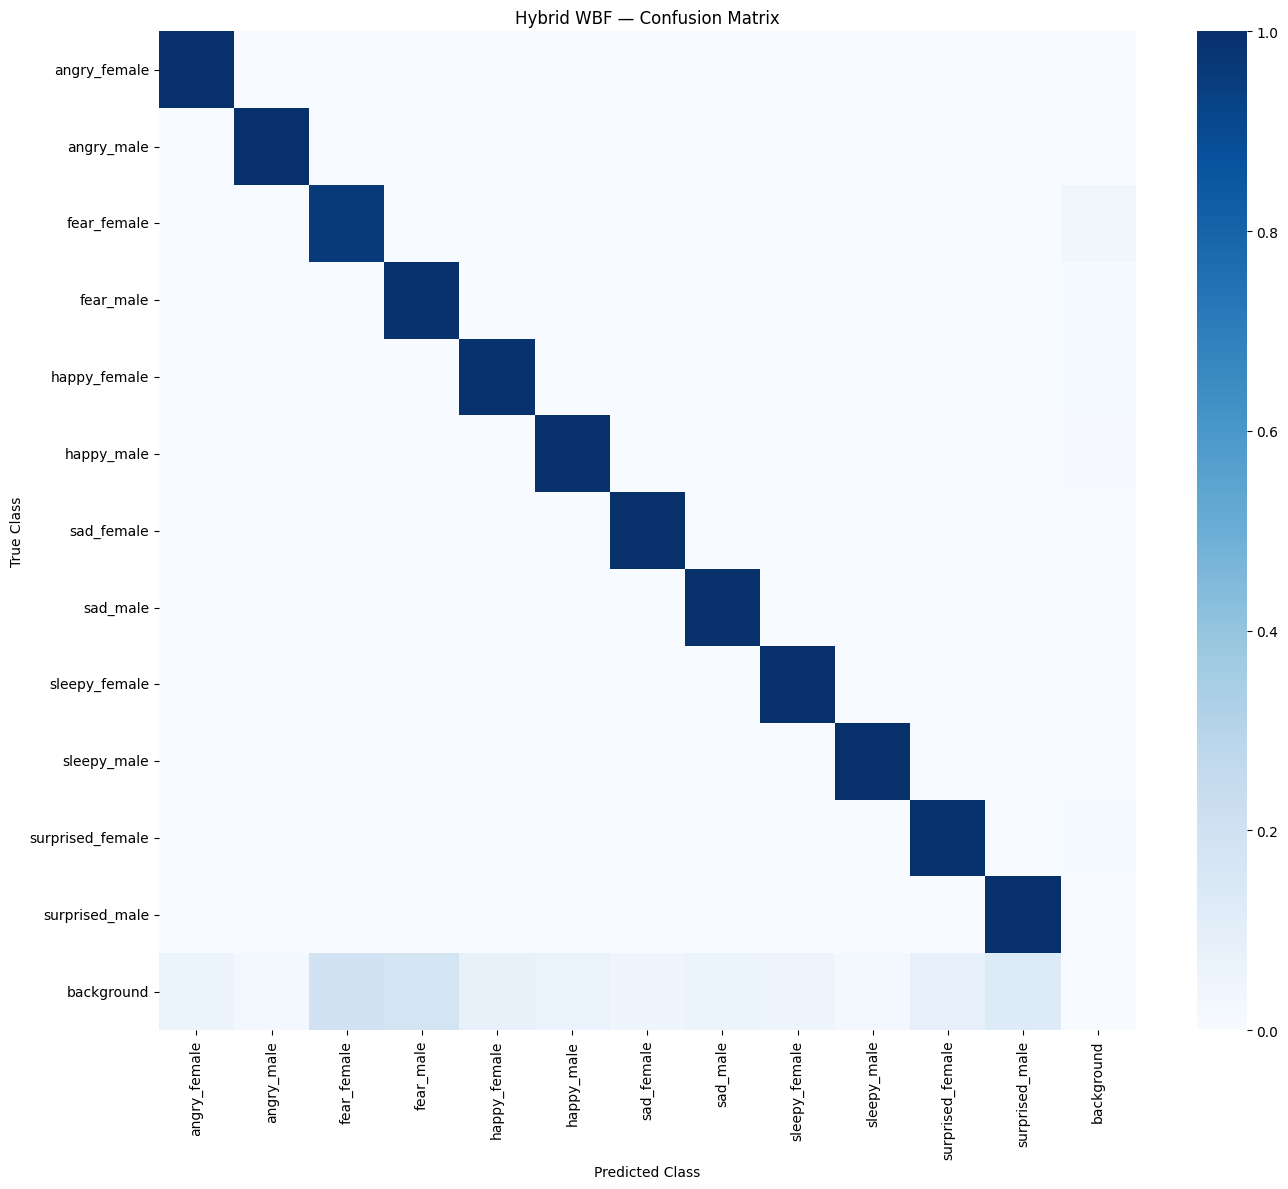

✅ Confusion matrix saved at: /content/hybrid_out/confusion_matrix.png


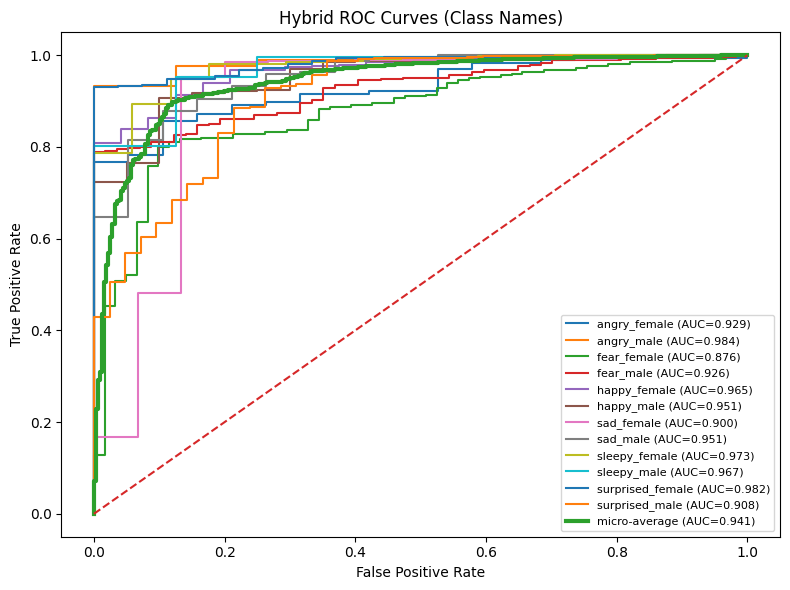

✅ Saved: /content/hybrid_out/roc_curve.png


In [ ]:
# ============================================================
# HYBRID EVALUATION (GT in /content/test_lbls, preds in hybrid_out)
# Metrics: Precision, Recall, mAP50, Confusion Matrix (normalized), ROC curve
# ============================================================

!pip -q install scikit-learn opencv-python matplotlib seaborn pandas tqdm

import os, glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ----------------------------
# PATHS (based on your structure)
# ----------------------------
IMG_DIR   = "/content/fer/train/images"
GT_DIR    = "/content/fer/train/labels"  # <-- your GT labels folder
PRED_CSV  = "/content/hybrid_out/hybrid_predictions.csv"
OUT_DIR   = "/content/hybrid_out"

os.makedirs(OUT_DIR, exist_ok=True)

assert os.path.isdir(IMG_DIR), "test_imgs folder not found!"
assert os.path.isdir(GT_DIR), "test_lbls folder not found!"
assert os.path.exists(PRED_CSV), "hybrid_predictions.csv not found!"

# ----------------------------
# Load predictions
# ----------------------------
dfp = pd.read_csv(PRED_CSV)
required_cols = {"image","cls_id","conf","x1","y1","x2","y2"}
missing = required_cols - set(dfp.columns)
assert len(missing) == 0, f"Missing columns in CSV: {missing}"

# Infer num classes from predictions + GT (safe)
pred_class_ids = set(dfp["cls_id"].astype(int).tolist())
gt_class_ids = set()

# ----------------------------
# Image list
# ----------------------------
img_exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
imgs = []
for e in img_exts:
    imgs += glob.glob(os.path.join(IMG_DIR, e))
imgs = sorted(imgs)
assert len(imgs) > 0, "No images found in test_imgs"

# ----------------------------
# Helpers
# ----------------------------
def load_yolo_gt(label_path, img_w, img_h):
    """
    YOLO GT txt: cls xc yc w h (normalized)
    """
    if not os.path.exists(label_path):
        return np.zeros((0,4)), np.zeros((0,), dtype=int)

    boxes, labels = [], []
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            cls = int(float(parts[0]))
            xc, yc, bw, bh = map(float, parts[1:5])

            x1 = (xc - bw/2) * img_w
            y1 = (yc - bh/2) * img_h
            x2 = (xc + bw/2) * img_w
            y2 = (yc + bh/2) * img_h

            boxes.append([x1,y1,x2,y2])
            labels.append(cls)

    return np.array(boxes, float), np.array(labels, int)

def iou_one_to_many(a, b):
    """
    a: (4,) xyxy
    b: (N,4)
    """
    if b.shape[0] == 0:
        return np.zeros((0,))
    xA = np.maximum(a[0], b[:,0])
    yA = np.maximum(a[1], b[:,1])
    xB = np.minimum(a[2], b[:,2])
    yB = np.minimum(a[3], b[:,3])
    inter = np.maximum(0, xB-xA) * np.maximum(0, yB-yA)
    area_a = np.maximum(0, a[2]-a[0]) * np.maximum(0, a[3]-a[1])
    area_b = np.maximum(0, b[:,2]-b[:,0]) * np.maximum(0, b[:,3]-b[:,1])
    union = area_a + area_b - inter + 1e-9
    return inter / union

def greedy_match(pred_xyxy, pred_scores, pred_cls, gt_xyxy, gt_cls, iou_thr=0.5):
    """
    Greedy match: predictions sorted by score desc,
    match to unused GT of same class with IoU>=thr.
    """
    if len(pred_scores) == 0:
        fn_by_class = {}
        for c in gt_cls:
            c=int(c)
            fn_by_class[c] = fn_by_class.get(c, 0) + 1
        return (np.zeros((0,),int), np.zeros((0,),float), np.zeros((0,),int),
                np.zeros((0,),int), fn_by_class)

    order = np.argsort(-pred_scores)
    pred_xyxy   = pred_xyxy[order]
    pred_scores = pred_scores[order]
    pred_cls    = pred_cls[order]

    gt_used = np.zeros(len(gt_cls), dtype=bool)

    y_true, y_score, y_pcls, gt_for_conf = [], [], [], []
    for pb, ps, pc in zip(pred_xyxy, pred_scores, pred_cls):
        pc = int(pc)
        cand = np.where((gt_cls == pc) & (~gt_used))[0]
        if len(cand) == 0:
            y_true.append(0); y_score.append(ps); y_pcls.append(pc); gt_for_conf.append(-1)
            continue

        ious = iou_one_to_many(pb, gt_xyxy[cand])
        best_local = np.argmax(ious)
        best_gt = cand[best_local]

        if ious[best_local] >= iou_thr:
            gt_used[best_gt] = True
            y_true.append(1); y_score.append(ps); y_pcls.append(pc); gt_for_conf.append(int(gt_cls[best_gt]))
        else:
            y_true.append(0); y_score.append(ps); y_pcls.append(pc); gt_for_conf.append(-1)

    fn_by_class = {}
    for c in gt_cls[~gt_used]:
        c=int(c)
        fn_by_class[c] = fn_by_class.get(c, 0) + 1

    return (np.array(y_true), np.array(y_score), np.array(y_pcls), np.array(gt_for_conf), fn_by_class)

def average_precision(y_true, y_score):
    """
    AP via area under PR curve (numeric integration).
    """
    if len(y_true) == 0:
        return np.nan
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    if np.sum(y_true) == 0:
        return 0.0

    order = np.argsort(-y_score)
    y_true = y_true[order]
    tp = np.cumsum(y_true)
    fp = np.cumsum(1 - y_true)
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (np.sum(y_true) + 1e-9)
    return np.trapz(prec, rec)

# ----------------------------
# Class count detection from GT
# ----------------------------
for p in imgs:
    base = os.path.splitext(os.path.basename(p))[0]
    gt_path = os.path.join(GT_DIR, base + ".txt")
    if os.path.exists(gt_path):
        with open(gt_path,"r") as f:
            for line in f:
                line=line.strip()
                if not line:
                    continue
                gt_class_ids.add(int(float(line.split()[0])))

all_class_ids = sorted(set(pred_class_ids) | set(gt_class_ids))
NUM_CLASSES = (max(all_class_ids)+1) if len(all_class_ids) else 0
assert NUM_CLASSES > 0, "Could not infer number of classes."

print("✅ Inferred NUM_CLASSES =", NUM_CLASSES)

# ----------------------------
# Evaluation settings
# ----------------------------
IOU_THR = 0.5
CONF_THR = 0.25  # use same threshold you used for saving predictions

# For metrics aggregation
all_tp=all_fp=all_fn=0
tp_c = np.zeros(NUM_CLASSES, int)
fp_c = np.zeros(NUM_CLASSES, int)
fn_c = np.zeros(NUM_CLASSES, int)

roc_y_true = [[] for _ in range(NUM_CLASSES)]
roc_y_score = [[] for _ in range(NUM_CLASSES)]

y_true_conf = []
y_pred_conf = []

# ----------------------------
# Evaluate per-image
# ----------------------------
for p in tqdm(imgs, desc="Evaluating Hybrid"):
    img = cv2.imread(p)
    if img is None:
        continue
    h, w = img.shape[:2]
    base = os.path.splitext(os.path.basename(p))[0]

    # GT
    gt_path = os.path.join(GT_DIR, base + ".txt")
    gt_xyxy, gt_cls = load_yolo_gt(gt_path, w, h)

    # Predictions for this image from CSV
    sub = dfp[dfp["image"] == os.path.basename(p)].copy()
    if len(sub) > 0:
        sub = sub[sub["conf"] >= CONF_THR]
        pred_xyxy = sub[["x1","y1","x2","y2"]].values.astype(float)
        pred_scores = sub["conf"].values.astype(float)
        pred_cls = sub["cls_id"].values.astype(int)
    else:
        pred_xyxy = np.zeros((0,4), float)
        pred_scores = np.zeros((0,), float)
        pred_cls = np.zeros((0,), int)

    y_true, y_score, y_pcls, gt_for_conf, fn_by_class = greedy_match(
        pred_xyxy, pred_scores, pred_cls, gt_xyxy, gt_cls, iou_thr=IOU_THR
    )

    # update TP/FP and ROC buffers
    for t, s, c in zip(y_true, y_score, y_pcls):
        c = int(c)
        if t == 1:
            tp_c[c] += 1
            all_tp += 1
        else:
            fp_c[c] += 1
            all_fp += 1
        roc_y_true[c].append(int(t))
        roc_y_score[c].append(float(s))

    # update FN
    for c, cnt in fn_by_class.items():
        fn_c[c] += cnt
        all_fn += cnt

    # confusion pairs (prediction entries)
    for gc, pc in zip(gt_for_conf, y_pcls):
        y_true_conf.append(int(gc))  # -1 means background true
        y_pred_conf.append(int(pc))

    # add missed GT as pred background (-1)
    for c, cnt in fn_by_class.items():
        for _ in range(cnt):
            y_true_conf.append(int(c))
            y_pred_conf.append(-1)

# ----------------------------
# Compute metrics
# ----------------------------
precision = all_tp / (all_tp + all_fp + 1e-9)
recall    = all_tp / (all_tp + all_fn + 1e-9)

ap_list = []
for c in range(NUM_CLASSES):
    ap_list.append(average_precision(roc_y_true[c], roc_y_score[c]))
map50 = np.nanmean(ap_list)

print("\n=================================================")
print("✅ HYBRID EVALUATION (IoU=0.5)")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"mAP50    : {map50:.4f}")
print("=================================================")

# Save metrics to file
metric_path = os.path.join(OUT_DIR, "hybrid_metrics.txt")
with open(metric_path, "w") as f:
    f.write(f"Precision: {precision:.6f}\n")
    f.write(f"Recall   : {recall:.6f}\n")
    f.write(f"mAP50    : {map50:.6f}\n")
print("✅ Saved:", metric_path)

# ----------------------------
# Confusion Matrix (Normalized) with background=-1
# ----------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------
# Prepare class names (ordered by class index)
# ------------------------------------------------
if isinstance(names, dict):
    class_names = [names[i] for i in range(len(names))]
else:
    class_names = names

# Add background class
labels_with_bg = list(range(NUM_CLASSES)) + [-1]
names_with_bg  = class_names + ["background"]

# ------------------------------------------------
# Compute confusion matrix
# ------------------------------------------------
cm = confusion_matrix(
    y_true_conf,      # true labels (includes -1 for background)
    y_pred_conf,      # predicted labels (includes -1)
    labels=labels_with_bg
)

# Normalize row-wise (true-class normalization)
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-9)

# ------------------------------------------------
# Plot
# ------------------------------------------------
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    cmap="Blues",
    xticklabels=names_with_bg,
    yticklabels=names_with_bg,
    cbar=True
)

plt.title("Hybrid WBF — Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save
cm_path = "/content/hybrid_out/confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
plt.show()

print("✅ Confusion matrix saved at:", cm_path)

# ----------------------------
# ROC Curve (per class + micro) WITH CLASS NAMES
# ----------------------------

# Build class_names safely
if isinstance(names, dict):
    class_names = [names[i] for i in range(NUM_CLASSES)]
else:
    class_names = list(names[:NUM_CLASSES])

plt.figure(figsize=(8, 6))
plotted = False

for c in range(NUM_CLASSES):
    yt = np.array(roc_y_true[c])
    ys = np.array(roc_y_score[c])

    # need both positive and negative
    if len(np.unique(yt)) < 2:
        continue

    fpr, tpr, _ = roc_curve(yt, ys)
    roc_auc = auc(fpr, tpr)

    cls_name = class_names[c] if c < len(class_names) else f"class_{c}"
    plt.plot(fpr, tpr, label=f"{cls_name} (AUC={roc_auc:.3f})")
    plotted = True

# micro-average
all_yt = np.concatenate([
    np.array(roc_y_true[c]) for c in range(NUM_CLASSES) if len(roc_y_true[c]) > 0
])
all_ys = np.concatenate([
    np.array(roc_y_score[c]) for c in range(NUM_CLASSES) if len(roc_y_score[c]) > 0
])

if len(np.unique(all_yt)) >= 2:
    fpr, tpr, _ = roc_curve(all_yt, all_ys)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=3, label=f"micro-average (AUC={roc_auc:.3f})")
    plotted = True

if plotted:
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Hybrid ROC Curves (Class Names)")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()

    roc_path = os.path.join(OUT_DIR, "roc_curve.png")
    plt.savefig(roc_path, dpi=200)
    plt.show()
    print("✅ Saved:", roc_path)
else:
    print("⚠️ ROC skipped: not enough positive/negative samples to compute ROC.")

In [ ]:
from google.colab import files
import shutil

# Replace 'your_folder' with the folder you want to download
folder_name = "/content/hybrid_out"
zip_name = f"{folder_name}.zip"

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
files.download(zip_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>